In [2]:
# importing libraries

# for processing
import numpy as np
import pandas as pd

# visualisation
import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use("dark_background")

# other necessary libraries
import datetime
from collections import Counter
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
# calls_path="/kaggle/input/dataset/calls.csv"
# customer_path="/kaggle/input/dataset/customers.csv"
# reason_path="/kaggle/input/dataset/reason.csv"
# sentiment_stat="/kaggle/input/dataset/sentiment_statistic.csv"
# test_path="/kaggle/input/dataset/test.csv"

calls_path = "DataSet/callsf0d4f5a.csv"
customer_path = "DataSet/customers2afd6ea.csv"
reason_path = "DataSet/reason18315ff.csv"
sentiment_stat = "DataSet/sentiment_statisticscc1e57a.csv"
test_path = "DataSet/testbc7185d.csv"

In [4]:
df_calls = pd.read_csv(calls_path)
df_calls.sample(5)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript
41380,7229039328,4572301914,575830,8/18/2024 10:55,8/18/2024 10:58,8/18/2024 11:49,\n\nAgent: Thank you for calling United Airlin...
66601,5912036669,5556589605,348998,8/30/2024 15:10,8/30/2024 15:14,8/30/2024 15:23,\n\nAgent: Thank you for calling United Airlin...
2975,1557447040,8357392613,215457,8/3/2024 4:45,8/3/2024 4:55,8/3/2024 6:51,\n\nAgent: Thank you for calling United Airlin...
8164,7124621121,637416505,910145,8/4/2024 8:18,8/4/2024 8:25,8/4/2024 8:26,\n\nAgent: Thank you for calling United Airlin...
15500,1997986457,8965450475,782403,8/7/2024 12:46,8/7/2024 12:55,8/7/2024 12:59,\n\nAgent: Thank you for calling United Airlin...


#### we don't need `call_transcripts` right now (to solve our current problem, but we'll use it later to solve another problem)

In [5]:
df_calls=df_calls.drop("call_transcript",axis=1)
df_calls[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23


#### We'll calculate `handle_time` (i.e. time from when the agent picks up the call to when they hang up) and `waiting_time` (i.e. time spent by the customer in queue till the agent answers the call) for each `call_id` and add them as columns to our `df_call` dataframe

In [97]:
# Convert the columns to datetime format
df_calls["call_start_datetime"] = pd.to_datetime(
    df_calls["call_start_datetime"], format="%m/%d/%Y %H:%M"
)
df_calls["agent_assigned_datetime"] = pd.to_datetime(
    df_calls["agent_assigned_datetime"], format="%m/%d/%Y %H:%M"
)
df_calls["call_end_datetime"] = pd.to_datetime(
    df_calls["call_end_datetime"], format="%m/%d/%Y %H:%M"
)

# Calculate wait_time (in minutes) and call_duration (in minutes)
df_calls["waiting_time"] = (
    df_calls["agent_assigned_datetime"] - df_calls["call_start_datetime"]
).dt.total_seconds() / 60
df_calls["handle_time"] = (
    df_calls["call_end_datetime"] - df_calls["agent_assigned_datetime"]
).dt.total_seconds() / 60

#### If we're able to find features that have a positive or negative correlation with `handle_time` and `waiting_time` for each call (i.e., each `call_id`), we can reduce both, which will in turn reduce AHT and AST automatically, since AHT and AST are essentially averages over the total number of calls.

#### So, in our case here:
#### Average Handle Time (AHT):
$$ \text{AHT} = \frac{\sum_{i=1}^{n} \text{handle_time}_i}{n} $$

#### Average Speed to Answer (AST):
$$ \text{AST} = \frac{\sum_{i=1}^{n} \text{waiting_time}_i}{n} $$

#### Here, `n` is total number of `call_id`


In [98]:
df_calls[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent,agent_assigned_day,agent_assigned_week_day
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,2024-08-01,1,1,Thursday
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,2024-08-01,1,1,Thursday
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,2024-08-01,1,1,Thursday
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,2024-08-01,1,1,Thursday
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,2024-08-01,1,1,Thursday


In [99]:
# sort by call_start_datetime for chronological flow in data
df_calls.describe()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,agent_assigned_day
count,7.181000e+04,7.181000e+04,71810.000000,71810,71810,71810,71810.000000,71810.000000,71810.000000,71810.000000
mean,4.993574e+09,5.004334e+09,564768.278039,2024-08-16 10:42:34.023116544,2024-08-16 10:49:51.090655744,2024-08-16 11:01:28.139256320,7.284459,11.617477,0.439535,15.911698
min,1.316420e+05,1.197800e+04,102574.000000,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:17:00,3.000000,0.000000,0.000000,1.000000
25%,2.480013e+09,2.514618e+09,347606.000000,2024-08-09 10:58:30,2024-08-09 11:07:15,2024-08-09 11:19:30,5.000000,4.000000,0.000000,9.000000
50%,4.989448e+09,4.999664e+09,591778.000000,2024-08-17 09:02:00,2024-08-17 09:08:00,2024-08-17 09:20:00,7.000000,7.000000,0.000000,17.000000
75%,7.493629e+09,7.509126e+09,786323.000000,2024-08-24 14:17:00,2024-08-24 14:24:45,2024-08-24 14:36:00,9.000000,15.000000,1.000000,24.000000
max,9.999806e+09,9.999935e+09,993862.000000,2024-08-31 23:55:00,2024-08-31 23:59:00,2024-09-01 01:33:00,15.000000,119.000000,1.000000,31.000000
std,2.889673e+09,2.884255e+09,257532.362167,NaN,NaN,NaN,2.518830,12.905025,0.496334,9.017795


### Observation: We find out that this data contains records about calls that were assigned to agents over a period of 1 month, starting from 01-08-2024 and ending on 31-08-2024 (DD-MM-YYYY)

In [100]:
# adding a column that only tracks the day on which the call was assigned to agent
df_calls["agent_assigned_date"] = df_calls["agent_assigned_datetime"].dt.date
df_calls[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent,agent_assigned_day,agent_assigned_week_day
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,2024-08-01,1,1,Thursday
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,2024-08-01,1,1,Thursday
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,2024-08-01,1,1,Thursday
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,2024-08-01,1,1,Thursday
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,2024-08-01,1,1,Thursday


# EDA (Exploratory Data Analysis)

In [101]:
# Lets calculate AST and AHT for our dataset, just as a small test
AST = np.mean(df_calls.waiting_time)
AHT = np.mean(df_calls.handle_time)
print(AST,AHT)

7.284458988998747 11.61747667455786


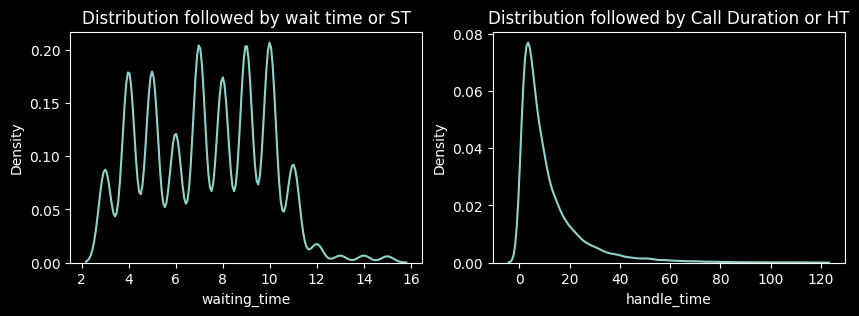

In [102]:
# KDE plot provides a smooth, continuous estimate of the distribution of a dataset, as opposed to a histogram

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sn.kdeplot(df_calls.waiting_time)
plt.title('Distribution followed by wait time or ST')

ax = plt.subplot(1,2,2)
sn.kdeplot(df_calls.handle_time)
plt.title('Distribution followed by Call Duration or HT')
plt.show()

In [17]:
len(df_calls["agent_assigned_date"].unique())

31

#### Observation: Work was done all 31 days, but we still don't know how many days an average worker works, that means we don't know average working days / working hours for an employe

### > Finding Effect of agent id on Time For Call

In [18]:
# Group by agent_id and calculate the mean of wait_time, call_duration, and unique count of agent_assigned_date
grouped_by_agent_df_calls = (
    df_calls.groupby("agent_id")
    .agg({"waiting_time": "mean", 
          "handle_time": "mean",
          "agent_assigned_date": "nunique"  # Number of days the agent(agent_id x) worked in that month
         })
    .reset_index()
)

# Rename the column for clarity
grouped_by_agent_df_calls.columns = [
    "agent_id",
    "avg_waiting_time",
    "avg_handle_time",
    "working_days",
]

grouped_by_agent_df_calls.sample(5)

,agent_id,avg_waiting_time,avg_handle_time,working_days
295,803198,7.194872,12.605128,14
66,266799,7.158301,11.849421,16
242,688153,7.319149,14.404255,9
107,369972,7.265509,11.575682,31
258,731015,7.148148,13.230453,16


In [21]:
# Count the occurrences of each agent_id in the original DataFrame
agent_counts = df_calls["agent_id"].value_counts().reset_index()
agent_counts.columns = ["agent_id", "call_count"]

# Merge the count with the grouped DataFrame
grouped_by_agent_df_calls = grouped_by_agent_df_calls.merge(agent_counts, on="agent_id", how="left")

grouped_by_agent_df_calls[:]

,agent_id,avg_waiting_time,avg_handle_time,working_days,call_count
0,102574,8.000000,60.000000,1,2
1,103651,7.013423,12.456376,16,298
2,106000,7.300885,11.486726,9,113
3,107876,7.833333,16.500000,3,6
4,112609,8.090909,14.181818,3,11
...,...,...,...,...,...
378,981776,7.145631,11.718447,16,309
379,981779,7.365639,11.396476,15,227
380,982131,7.277778,12.037037,16,270
381,992521,7.521739,15.826087,6,46


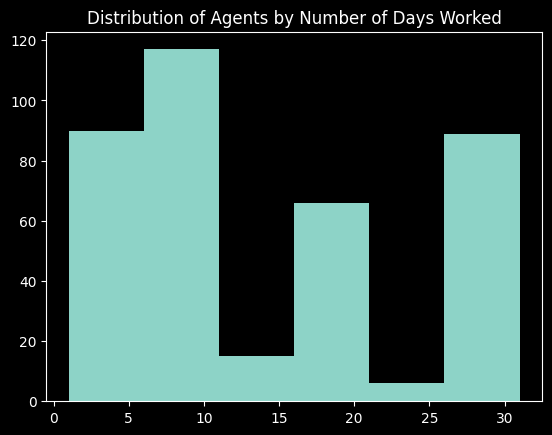

In [22]:
plt.hist(grouped_by_agent_df_calls.working_days, bins=6)
plt.title("Distribution of Agents by Number of Days Worked")
plt.show()

1000 minute work per month -> 0.66 hrs every day approx (assuming 25 days work month)

5000 minute work per month -> 3.5hrs hrs every day approx (assuming 25 days work month)

### > IVR Agent Segregation

In [23]:
ivr_agent_df_calls = grouped_by_agent_df_calls[grouped_by_agent_df_calls['working_days'] > 26]
print(Counter(ivr_agent_df_calls.working_days))

Counter({31: 83, 29: 2, 30: 1, 28: 1, 27: 1})


#### Implies We Can See we have around 83 to 90 ivr agents. As human agent cant work all 31 day , implies there are manny ivr agents

In [24]:
List = []
for agent in df_calls.agent_id.values:
    if(agent in ivr_agent_df_calls.agent_id.values):
        List.append(1)
    else:
        List.append(0)
print(f"Number Call handelled by IVR : {Counter(List)[0]} Non-IVR : {Counter(List)[1]}")

Number Call handelled by IVR : 40247 Non-IVR : 31563


In [25]:
df_calls['is_ivr_agent'] = List
df_calls[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,2024-08-01,1
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,2024-08-01,1
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,2024-08-01,1
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,2024-08-01,1
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,2024-08-01,1


#### > Even though ivr_agents are less than 1/3th of other agents , but there are handling more than 3/7 of calls.  

### Other Plots for Agents

In [26]:
grouped_by_agent_df_calls["total_handle_time"] = (
    grouped_by_agent_df_calls["avg_handle_time"] * grouped_by_agent_df_calls["call_count"]
)
grouped_by_agent_df_calls[:5]

,agent_id,avg_waiting_time,avg_handle_time,working_days,call_count,total_handle_time
0,102574,8.000000,60.000000,1,2,120.0
1,103651,7.013423,12.456376,16,298,3712.0
2,106000,7.300885,11.486726,9,113,1298.0
3,107876,7.833333,16.500000,3,6,99.0
4,112609,8.090909,14.181818,3,11,156.0


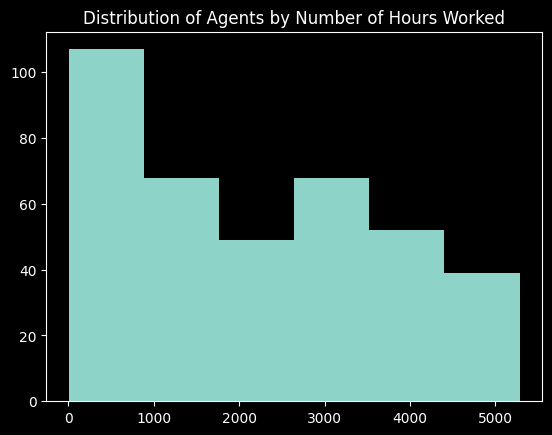

In [27]:
plt.hist(grouped_by_agent_df_calls.total_handle_time, bins=6)
plt.title("Distribution of Agents by Number of Hours Worked")
plt.show()

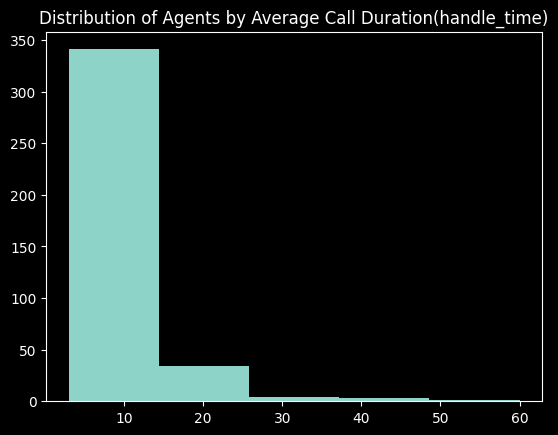

In [28]:
plt.hist(grouped_by_agent_df_calls.avg_handle_time, bins=5)
plt.title("Distribution of Agents by Average Call Duration(handle_time)")
plt.show()

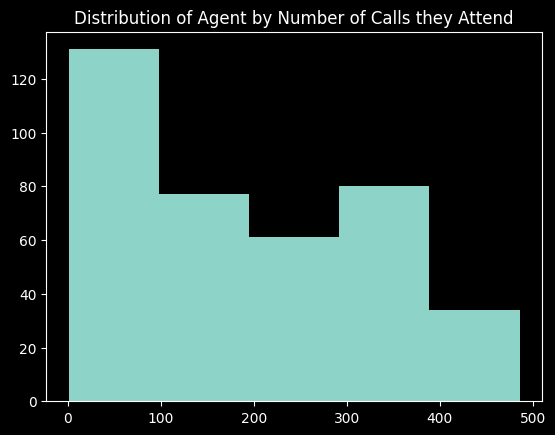

In [29]:
plt.hist(grouped_by_agent_df_calls.call_count, bins=5)
plt.title("Distribution of Agent by Number of Calls they Attend")
plt.show()

#### Observation: We had 383 agents working in the month, a big chunk of them only handle calls when our limited permanent agents are overburdened, ie temporary hires


### Next, we check how work is distributed over weekdays

we know 01-08-2024 was Thursday

In [30]:
df_calls["agent_assigned_day"] = [
    int(str(x).split("-")[-1]) for x in df_calls.agent_assigned_date.values
]

# Dictionary mapping numerical values to weekday strings
day_mapping = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

# Assigning the day names based on the calculated week day number
df_calls["agent_assigned_week_day"] = [
    day_mapping[(x+3)%7]
    for x in df_calls.agent_assigned_day.values
]

In [31]:
grouped_df = (
    df_calls.groupby("agent_assigned_week_day")
    .agg(
        {
            "waiting_time": "mean",
            "handle_time": "mean",
            "agent_id": "nunique",  # Count of unique agent_assigned_date per agent_id
            "customer_id": "nunique",
        }
    )
    .reset_index()
)

grouped_df.columns = [
    "agent_assigned_week_day",
    "avg_waiting_time",
    "avg_handle_time",
    "count_agent_id",
    "count_customer_id"
]


grouped_df = grouped_df.iloc[[3,1,5,6,4,0,2]]
grouped_df.reset_index(drop=True,inplace = True)
grouped_df

,agent_assigned_week_day,avg_waiting_time,avg_handle_time,count_agent_id,count_customer_id
0,Sunday,7.293063,11.642166,369,19129
1,Monday,7.251533,11.401149,171,5220
2,Tuesday,7.329157,11.322513,167,5268
3,Wednesday,7.325595,11.727220,174,5169
4,Thursday,7.293612,11.678286,186,6512
5,Friday,7.267277,11.708314,176,6555
6,Saturday,7.268272,11.644697,383,23957


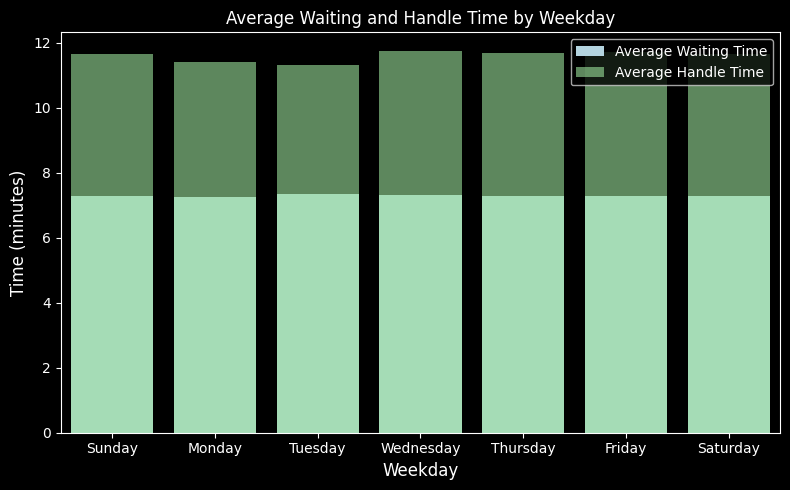

In [32]:
# Plotting
plt.figure(figsize=(8, 5))
sn.barplot(data=grouped_df, x='agent_assigned_week_day', y='avg_waiting_time', color='lightblue', label='Average Waiting Time')
sn.barplot(data=grouped_df, x='agent_assigned_week_day', y='avg_handle_time', color='lightgreen', label='Average Handle Time', alpha=0.6)

plt.title('Average Waiting and Handle Time by Weekday')
plt.xlabel('Weekday',fontsize = 12)
plt.ylabel('Time (minutes)',fontsize = 12)
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

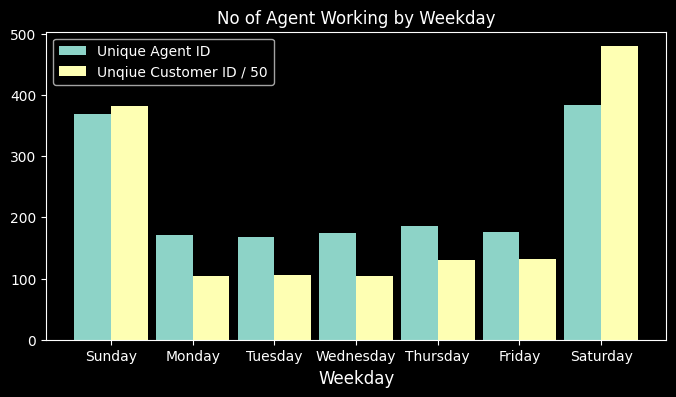

In [33]:
plt.figure(figsize=(8, 4))
plt.bar(
    grouped_df.agent_assigned_week_day,
    grouped_df.count_agent_id,
    width=-0.45,
    label="Unique Agent ID",
    align="edge",
)
plt.bar(
    grouped_df.agent_assigned_week_day,
    grouped_df.count_customer_id / 50,
    align="edge",
    width=0.45,
    label="Unqiue Customer ID / 50",
)

plt.legend()
plt.xlabel('Weekday',fontsize = 12)
plt.title("No of Agent Working by Weekday")
plt.show()

#### Observation: We find out there's no difference in work based on weekdays, but no of agents working might be different for each weekday 

### Next we check for peak working hours thoughout each day

### > Peak Time Distribution

In [34]:
def convert_to_minutes(y):  # it is in np.datatime64 format
    # Extract components using NumPy
    dt = datetime.datetime.strptime(str(y)[:-3], "%Y-%m-%dT%H:%M:%S.%f")

    # Extract minute, day, month, and hour
    minutes = dt.minute
    day = dt.day - 1
    month = dt.month - 8
    hours = dt.hour
    # Convert to total minutes
    total_minutes = (
        (month * 31 * 24 * 60) + (day * 24 * 60) + (hours * 60) + minutes
    )  # Assuming average of 30 days per month
    return total_minutes

In [35]:
df_calls.sample()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent,agent_assigned_day,agent_assigned_week_day
48148,4944935083,1183572148,633922,2024-08-21 16:37:00,2024-08-21 16:42:00,2024-08-21 16:49:00,5.0,7.0,2024-08-21,1,21,Wednesday


In [36]:
Booked_hours = {i:0 for i in range(24)}
for x, y in tqdm(df_calls[["agent_assigned_datetime", "call_end_datetime"]].values):
    x_time = convert_to_minutes(x)
    y_time = convert_to_minutes(y)
    for i in range(x_time, y_time, 1):
        mod = i % (24 * 60)
        Booked_hours[mod // 60] += 1
Booked_hours = {hour:count//31 for hour,count in Booked_hours.items()}

100%|██████████| 71810/71810 [00:12<00:00, 5896.92it/s]


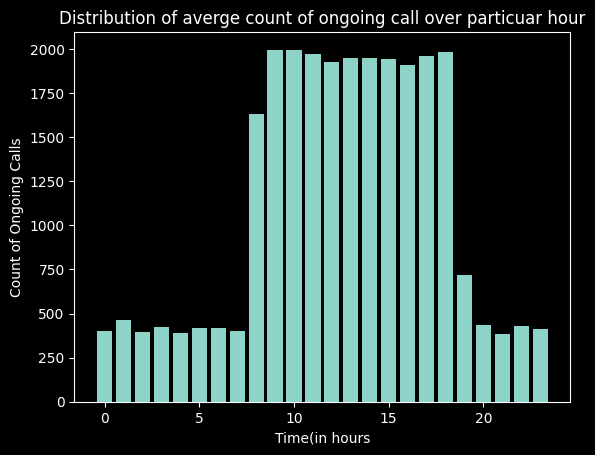

In [37]:
plt.bar(Booked_hours.keys(),Booked_hours.values())
plt.title("Distribution of averge count of ongoing call over particuar hour")
plt.xlabel('Time(in hours')
plt.ylabel("Count of Ongoing Calls")
plt.show()

In [38]:
# peek hours were 8 am to 18 pm 
peak_call_duration = []
non_peak_call_duration = []
peak_wait_time = []
non_peak_wait_time =[ ]
for dt,cd,wt in tqdm(df_calls[["call_start_datetime","handle_time","waiting_time"]].values):
    time = str(dt).split(' ')[-1]
    hour = int(time.split(':')[0]) #Converted into hours .
    if(8 <= hour and hour <=18): # Peak Hours 
        peak_call_duration.append(cd)
        peak_wait_time.append(wt)
    else:                     # Non peak Hours
        non_peak_call_duration.append(cd)
        non_peak_wait_time.append(wt)

100%|██████████| 71810/71810 [00:02<00:00, 31344.93it/s]


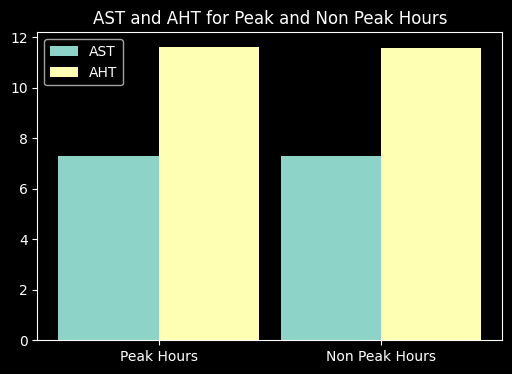

In [39]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["Peak Hours","Non Peak Hours"],
    [np.mean(peak_wait_time),np.mean(non_peak_wait_time)],
    width = -0.45,
    label = "AST",
    align = "edge",
)
plt.bar(
    ["Peak Hours","Non Peak Hours"],
    [np.mean(peak_call_duration),np.mean(non_peak_call_duration)],
    align = "edge",
    width = 0.45,
    label = "AHT",
)
plt.title("AST and AHT for Peak and Non Peak Hours")
plt.legend()
plt.show()

#### Implies there is no effect of peak hour on AHT and AST

## > Analysis on Sentiments and Reason for Calling 

In [40]:
df_sentiment = pd.read_csv(sentiment_stat)

In [41]:
df_sentiment[:5]

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35


In [42]:
merged_df = pd.merge(
    df_calls, df_sentiment, on=["call_id", "agent_id"], how="inner"
)

In [43]:
merged_df[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent,agent_assigned_day,agent_assigned_week_day,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,2024-08-01,1,1,Thursday,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,2024-08-01,1,1,Thursday,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,2024-08-01,1,1,Thursday,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,2024-08-01,1,1,Thursday,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,2024-08-01,1,1,Thursday,neutral,polite,-0.05,0.35


In [44]:
merged_df = merged_df.drop(
    ["agent_assigned_date", "agent_assigned_week_day", "agent_assigned_day"], axis=1
)

In [45]:
merged_df[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,1,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,1,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,1,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,1,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,1,neutral,polite,-0.05,0.35


In [46]:
merged_df["customer_tone"].unique()

array(['angry', 'neutral', 'polite', 'frustrated', 'calm'], dtype=object)

In [47]:
merged_df_encoded = pd.get_dummies(
    merged_df, columns=["agent_tone", "customer_tone"], dtype="int"
)
merged_df_encoded.sample(5)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,average_sentiment,...,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite
65958,9997917138,719355265,605855,2024-08-30 08:20:00,2024-08-30 08:25:00,2024-08-30 08:28:00,5.0,3.0,0,0.08,...,0,1,0,0,0,0,0,1,0,0
32668,4126670589,4367248881,878048,2024-08-15 09:50:00,2024-08-15 09:53:00,2024-08-15 09:59:00,3.0,6.0,1,0.02,...,0,1,0,0,0,0,0,0,1,0
1993,861246206,7093989709,251287,2024-08-02 13:16:00,2024-08-02 13:26:00,2024-08-02 14:04:00,10.0,38.0,1,-0.02,...,0,0,0,1,0,0,1,0,0,0
57403,3944653723,6126223961,178998,2024-08-25 10:41:00,2024-08-25 10:49:00,2024-08-25 11:02:00,8.0,13.0,0,0.15,...,0,1,0,0,0,0,0,1,0,0
35198,2616744989,6776771000,878048,2024-08-17 03:49:00,2024-08-17 03:52:00,2024-08-17 03:54:00,3.0,2.0,1,0.23,...,0,1,0,0,0,1,0,0,0,0


In [48]:
df_reason = pd.read_csv(reason_path)

In [49]:
merged_df_encoded = pd.merge(merged_df_encoded, df_reason, on="call_id", how="inner")
merged_df_encoded[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,average_sentiment,...,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,primary_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,1,-0.04,...,0,0,1,0,1,0,0,0,0,Voluntary Cancel
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,1,0.02,...,1,0,0,0,0,0,0,1,0,Booking
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,1,-0.13,...,0,0,1,0,0,0,0,0,1,IRROPS
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,1,-0.20,...,0,0,1,0,0,0,1,0,0,Upgrade
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,1,-0.05,...,0,0,1,0,0,0,0,0,1,Seating


## primary_call_reason column has categorical values that are spelled with different amounts of spaces, hence dataframe is treating each as different values, causing get_dummies(One Hot Encoder in Pandas Dataframe) to create more columns than there should be

In [50]:
uniques = np.unique(merged_df_encoded["primary_call_reason"])
print(len(uniques))
uniques

54


array([' Baggage', 'Baggage', 'Baggage  ', 'Booking', 'Booking  ',
       'Check In', 'Check-In', 'Check-In  ', 'Checkout', 'Checkout  ',
       'Communications', 'Communications  ', 'Digital   Support',
       'Digital  Support', 'Digital Support', 'Digital Support  ',
       'Disability', 'Disability  ', 'ETC', 'ETC  ', 'IRROPS', 'IRROPS  ',
       'Mileage   Plus', 'Mileage  Plus', 'Mileage Plus',
       'Mileage Plus  ', 'Other  Topics', 'Other Topics',
       'Other Topics  ', 'Post Flight', 'Post-Flight', 'Post-Flight  ',
       'Products & Services', 'Products and Services',
       'Products and Services  ', 'Schedule Change', 'Schedule Change  ',
       'Seating', 'Seating  ', 'Traveler   Updates', 'Traveler  Updates',
       'Traveler Updates', 'Traveler Updates  ', 'Unaccompanied Minor',
       'Unaccompanied Minor  ', 'Upgrade', 'Upgrade  ',
       'Voluntary   Change', 'Voluntary  Cancel', 'Voluntary  Change',
       'Voluntary Cancel', 'Voluntary Cancel  ', 'Voluntary Chan

In [51]:
# Assuming 'category_column' is the name of the column with the categorical variables
merged_df_encoded["primary_call_reason"] = (
    merged_df_encoded["primary_call_reason"]
    .str.strip()
    .str.replace(r"\s+|-|&|and", " ", regex=True)
)

uniques = np.unique(merged_df_encoded["primary_call_reason"])
print(len(uniques))
uniques

20


array(['Baggage', 'Booking', 'Check In', 'Checkout', 'Communications',
       'Digital Support', 'Disability', 'ETC', 'IRROPS', 'Mileage Plus',
       'Other Topics', 'Post Flight', 'Products   Services',
       'Schedule Change', 'Seating', 'Traveler Updates',
       'Unaccompanied Minor', 'Upgrade', 'Voluntary Cancel',
       'Voluntary Change'], dtype=object)

In [52]:
merged_df_encoded[:5]

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,average_sentiment,...,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,primary_call_reason
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,7.0,31.0,1,-0.04,...,0,0,1,0,1,0,0,0,0,Voluntary Cancel
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,3.0,12.0,1,0.02,...,1,0,0,0,0,0,0,1,0,Booking
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,8.0,19.0,1,-0.13,...,0,0,1,0,0,0,0,0,1,IRROPS
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,5.0,7.0,1,-0.20,...,0,0,1,0,0,0,1,0,0,Upgrade
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,10.0,9.0,1,-0.05,...,0,0,1,0,0,0,0,0,1,Seating


In [53]:
merged_df_encoded_2 = pd.get_dummies(
    merged_df_encoded, columns=["primary_call_reason"], dtype="int"
)

In [54]:
corr_df = merged_df_encoded_2.iloc[:, 6:]
corr_df[:5]

,waiting_time,handle_time,is_ivr_agent,average_sentiment,silence_percent_average,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,...,primary_call_reason_Other Topics,primary_call_reason_Post Flight,primary_call_reason_Products Services,primary_call_reason_Schedule Change,primary_call_reason_Seating,primary_call_reason_Traveler Updates,primary_call_reason_Unaccompanied Minor,primary_call_reason_Upgrade,primary_call_reason_Voluntary Cancel,primary_call_reason_Voluntary Change
0,7.0,31.0,1,-0.04,0.39,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,12.0,1,0.02,0.35,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,19.0,1,-0.13,0.32,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,7.0,1,-0.20,0.20,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,10.0,9.0,1,-0.05,0.35,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [130]:
corr_df

,waiting_time,handle_time,is_ivr_agent,average_sentiment,silence_percent_average,agent_tone_angry,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,...,primary_call_reason_Other Topics,primary_call_reason_Post Flight,primary_call_reason_Products Services,primary_call_reason_Schedule Change,primary_call_reason_Seating,primary_call_reason_Traveler Updates,primary_call_reason_Unaccompanied Minor,primary_call_reason_Upgrade,primary_call_reason_Voluntary Cancel,primary_call_reason_Voluntary Change
0,7.0,31.0,1,-0.04,0.39,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,12.0,1,0.02,0.35,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,19.0,1,-0.13,0.32,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,7.0,1,-0.20,0.20,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,10.0,9.0,1,-0.05,0.35,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66648,6.0,10.0,0,-0.19,0.51,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
66649,9.0,28.0,0,0.05,0.34,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
66650,3.0,8.0,0,0.03,0.22,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
66651,6.0,6.0,0,0.05,0.42,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


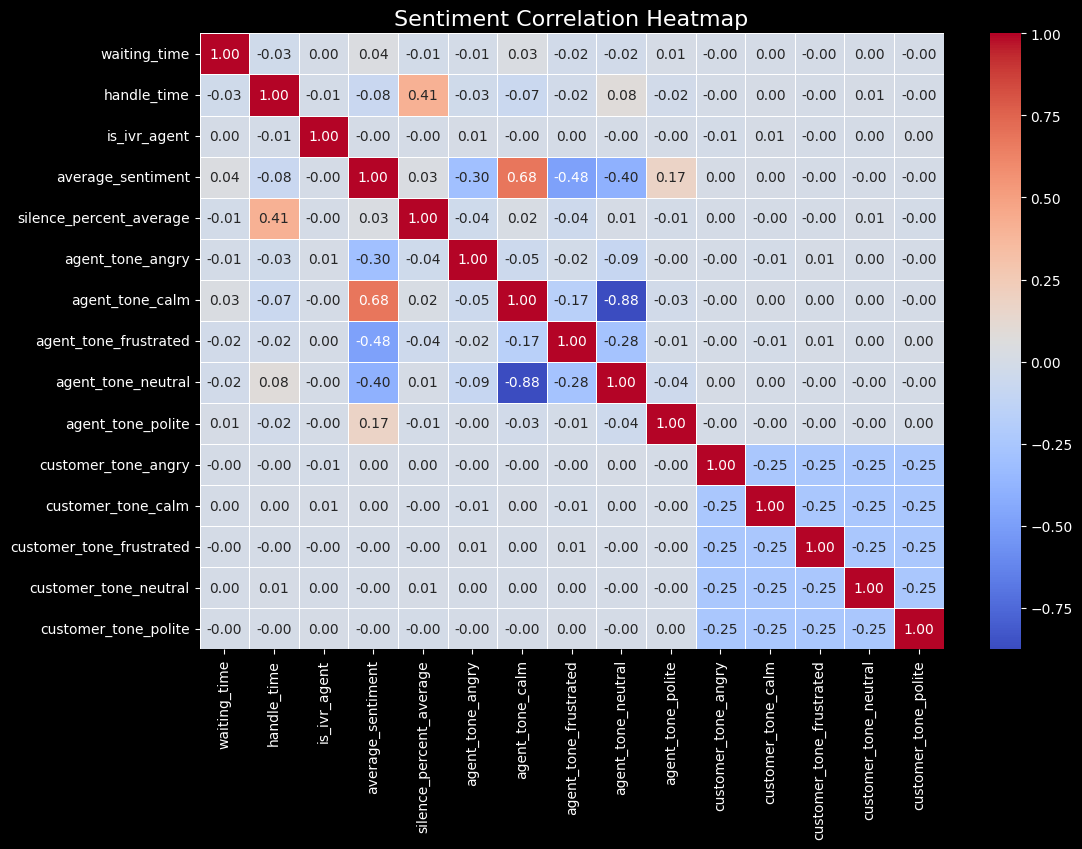

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the Pearson correlation matrix
correlation_matrx = corr_df.iloc[:, :15].corr()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.xticks(
    rotation=90,
)
# plt.yticks(rotation=45)
# Add titles and labels
plt.title("Sentiment Correlation Heatmap", fontsize=16)
plt.show()

## We found that sentiment data has no effect on wait time (obviously since agent and customer aren't talking/interacting)
## From correlation to sentiment data with call data(call duration) we found
## 1. Agent tone and Customer tone have very little to do with call duration
## 2. However, average silence percentage increase drastically increases call duration

In [59]:
new_corr = corr_df.iloc[:, 14:]
new_corr = pd.concat([new_corr, corr_df[["waiting_time", "handle_time"]]], axis=1)

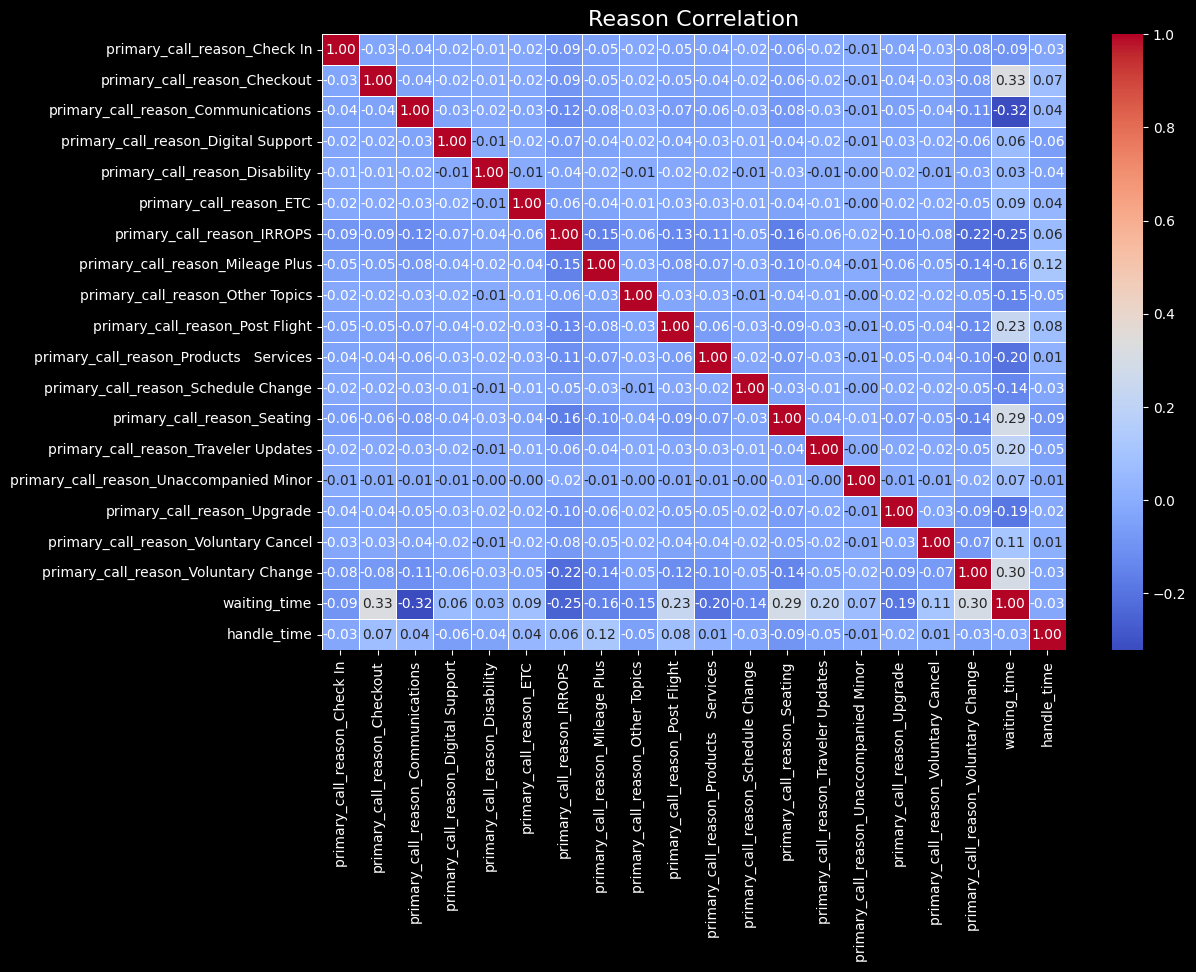

In [61]:
# Calculate the Pearson correlation matrix
correlation_matrix = new_corr.iloc[:, -20:].corr()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt="0.2f")
# plt.xticks(rotation=)
# plt.yticks(rotation=45)
# Add titles and labels
plt.title("Reason Correlation", fontsize=16)
plt.show()

In [62]:
merged_df_encoded.sample(5)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,average_sentiment,...,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,primary_call_reason
58914,5843917614,79166968,246791,2024-08-28 10:07:00,2024-08-28 10:14:00,2024-08-28 10:19:00,7.0,5.0,0,-0.06,...,0,0,1,0,1,0,0,0,0,Products Services
44819,8377427772,3927300920,910145,2024-08-21 18:08:00,2024-08-21 18:19:00,2024-08-21 18:29:00,11.0,10.0,1,0.04,...,1,0,0,0,0,0,0,0,1,Voluntary Change
21672,9813586454,2633796375,724683,2024-08-10 20:08:00,2024-08-10 20:14:00,2024-08-10 21:16:00,6.0,62.0,0,0.06,...,1,0,0,0,0,0,1,0,0,IRROPS
33272,1428516141,242735656,192245,2024-08-17 09:03:00,2024-08-17 09:10:00,2024-08-17 09:11:00,7.0,1.0,1,-0.11,...,0,0,1,0,0,0,0,0,1,IRROPS
37693,3259956394,9454460506,149315,2024-08-18 08:45:00,2024-08-18 08:49:00,2024-08-18 08:50:00,4.0,1.0,1,0.00,...,0,0,1,0,0,1,0,0,0,Communications


#### > Further Analysis of Primary Call Reasons

In [63]:
df_new_1 = (
    merged_df_encoded.groupby("primary_call_reason")
    .agg(
        {
            "waiting_time": "mean",
            "handle_time": "mean",
        }
    )
    .reset_index()
)
df_new_1.sample(5)

,primary_call_reason,waiting_time,handle_time
17,Upgrade,4.974799,10.539080
18,Voluntary Cancel,8.991910,12.031114
6,Disability,8.392060,4.868486
8,IRROPS,6.001352,13.085268
3,Checkout,12.078390,16.947564


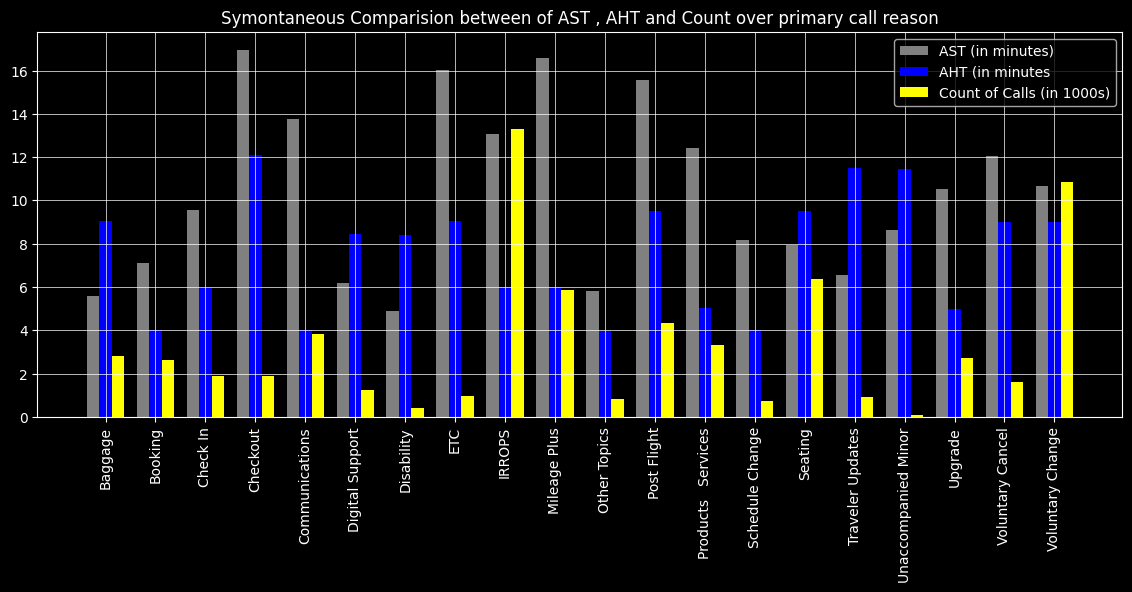

In [106]:
# Create the plot
fig, ax = plt.subplots(figsize = (14,5))
# Plotting each group's bars adjacent to each other
width = 0.25
x = np.arange(len(df_new_1.primary_call_reason)) 
ax.bar(x - width, 
                df_new_1.handle_time , 
                width, 
                label='AST (in minutes)',
                color = "gray"
               )
ax.bar(x, df_new_1.waiting_time, width, label='AHT (in minutes',color = "blue")

Count = dict(Counter(merged_df_encoded.primary_call_reason))
Count = [Count[x] / 1000 for x in list(df_new_1.primary_call_reason.values)]
ax.bar(x + width, Count, width, label="Count of Calls (in 1000s)",color = "yellow")

ax.set_xticks(x)
ax.set_xticklabels(df_new_1.primary_call_reason,rotation= 90)

plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.legend()
plt.grid(linewidth = 0.5)
plt.title("Symontaneous Comparision between of AST , AHT and Count over primary call reason")
plt.show()

#### IRROPS , Seating , Post Flight and Voluntory Change have been observed as one of the major reason leading higher time consumption.
#### But Reason like Checkout ,Digital Support ,ETXC ,Traveler Updates, Unaccompanied Minor and Voluntar Cancel have hight AHT and AST , but their count is low ,so there are also a concern.

In [107]:
merged_df_encoded.sample()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,is_ivr_agent,average_sentiment,...,agent_tone_calm,agent_tone_frustrated,agent_tone_neutral,agent_tone_polite,customer_tone_angry,customer_tone_calm,customer_tone_frustrated,customer_tone_neutral,customer_tone_polite,primary_call_reason
17130,9913352889,615656312,757349,2024-08-09 16:47:00,2024-08-09 16:52:00,2024-08-09 16:53:00,5.0,1.0,1,-0.13,...,0,0,1,0,0,0,1,0,0,Booking


### > Peak Hours Analysis for Primary Call Reason

In [108]:
# peek hours were 8 am to 18 pm 
peak_call_reason = {}
peak_call_reason = {}
for reason in np.unique(merged_df_encoded['primary_call_reason']):
    peak_call_reason[reason] = 0
    non_peak_call_reason[reason] = 0 
    
for dt,reason in tqdm(merged_df_encoded[["call_start_datetime","primary_call_reason"]].values):
    time = str(dt).split(' ')[-1]
    hour = int(time.split(':')[0]) #Converted into hours .
    if(8 <= hour and hour <=18): # Peak Hours 
        peak_call_reason[reason] += 1
    else:                     # Non peak Hours
        non_peak_call_reason[reason] += 1

100%|██████████| 66653/66653 [00:02<00:00, 32052.48it/s]


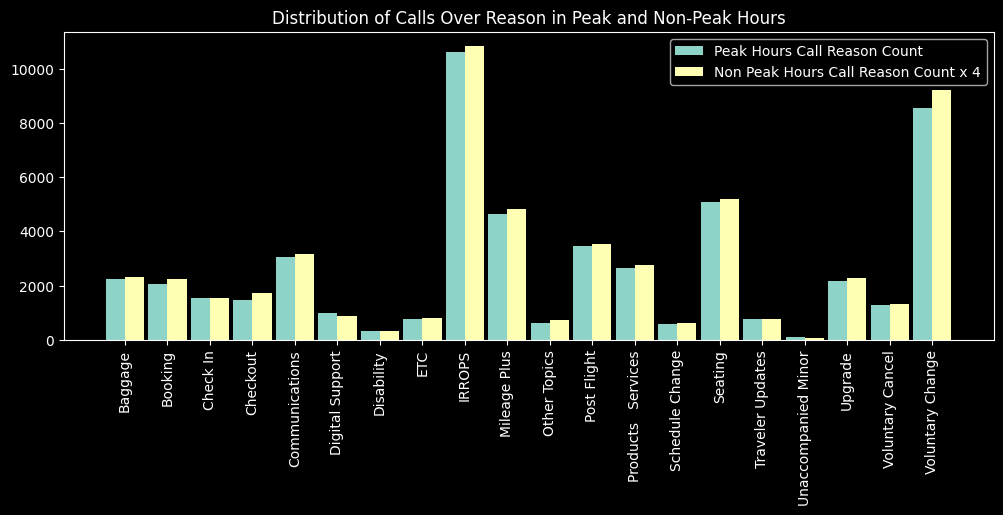

In [110]:
plt.figure(figsize=(12, 4))
plt.bar(
    peak_call_reason.keys(),
    peak_call_reason.values(),
    width = -0.45,
    label = "Peak Hours Call Reason Count",
    align = "edge",
)
plt.bar(
    non_peak_call_reason.keys(),
    np.array(list(non_peak_call_reason.values()))*4,
    align = "edge",
    width = 0.45,
    label = "Non Peak Hours Call Reason Count x 4",
)
plt.xticks(rotation=90)
plt.legend()
plt.title("Distribution of Calls Over Reason in Peak and Non-Peak Hours")
plt.show()

#### Implies weather it is peak hours or Non-peak hours ,there is effect on reason of calling,implied there relative ratio among reasons is still the same.   

In [111]:
Ivr_merged_df_encoded = merged_df_encoded[merged_df_encoded.is_ivr_agent==1]
Non_Ivr_merged_df_encoded = merged_df_encoded[merged_df_encoded.is_ivr_agent==0]

In [112]:
print(f"IVR AST :{np.mean(Ivr_merged_df_encoded.handle_time)} AHT :{np.mean(Ivr_merged_df_encoded.waiting_time)}")
print(f"Non IVR AST :{np.mean(Non_Ivr_merged_df_encoded.handle_time)} AHT :{np.mean(Non_Ivr_merged_df_encoded.waiting_time)}")

IVR AST :11.459500119670393 AHT :7.285294218210415
Non IVR AST :11.744800299417205 AHT :7.280970967224509


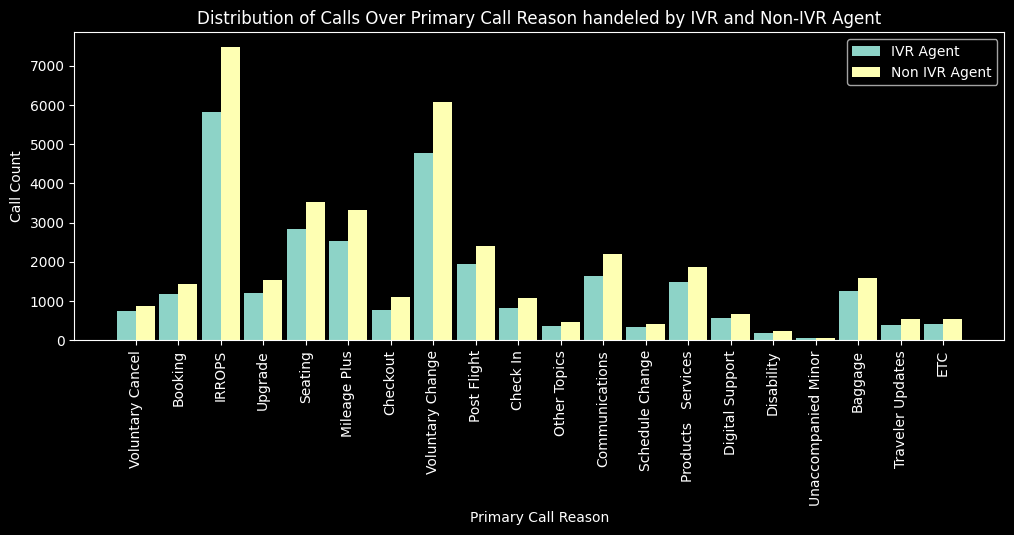

In [113]:
Dict1 = dict(Counter(Ivr_merged_df_encoded.primary_call_reason))
Dict2 = dict(Counter(Non_Ivr_merged_df_encoded.primary_call_reason))

plt.figure(figsize=(12, 4))
plt.bar(
    Dict1.keys(),
    Dict1.values(),
    width = -0.45,
    label = "IVR Agent",
    align = "edge",
)
plt.bar(
    Dict2.keys(),
    Dict2.values(),
    align = "edge",
    width = 0.45,
    label = "Non IVR Agent",
)
plt.xticks(rotation=90)
plt.legend()
plt.title("Distribution of Calls Over Primary Call Reason handeled by IVR and Non-IVR Agent")
plt.ylabel("Call Count")
plt.xlabel("Primary Call Reason")
plt.show()

#### There is no differnce we could see for call reason ,AHT and AST with respect to the agent handeling them is IVR or Non-IVR. 

### > Analysing Eline Code Distributions and Effects 

In [114]:
df_customer = pd.read_csv(customer_path)
df_customer.sample()

,customer_id,customer_name,elite_level_code
348,5846069673,Luis Simmons,3.0


In [115]:
df_customer.isna().sum()

customer_id             0
customer_name           0
elite_level_code    25767
dtype: int64

In [116]:
df_customer.drop("customer_name", inplace=True, axis=1)
df_customer.dropna(ignore_index=True, axis=0, inplace=True)

In [117]:
Counter(df_customer.elite_level_code)

Counter({0.0: 14387, 1.0: 14370, 2.0: 8028, 3.0: 5736, 4.0: 2125, 5.0: 1397})

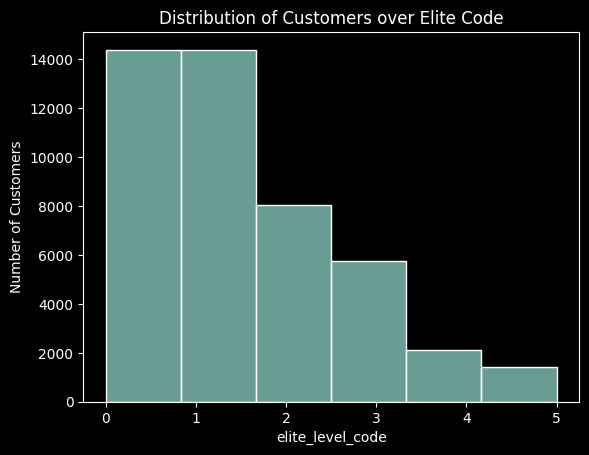

In [118]:
sns.histplot(df_customer.elite_level_code,bins=6)
plt.title("Distribution of Customers over Elite Code")
plt.ylabel("Number of Customers")
plt.show()

In [119]:
df_merged_1 = pd.merge(df_calls,df_customer,how = 'inner',on = 'customer_id')
df_merged_1 = pd.merge(df_merged_1,df_reason,how = 'inner',on = 'call_id')

df_merged_1["primary_call_reason"] = (
    df_merged_1["primary_call_reason"]
    .str.strip()
    .str.replace(r"\s+|-|&|and", " ", regex=True)
)

df_merged_1.sample(5)

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,waiting_time,handle_time,agent_assigned_date,is_ivr_agent,agent_assigned_day,agent_assigned_week_day,elite_level_code,primary_call_reason
19669,3827030726,1332456823,880532,2024-08-15 15:37:00,2024-08-15 15:45:00,2024-08-15 15:55:00,8.0,10.0,2024-08-15,1,15,Thursday,5.0,IRROPS
27684,742194837,1847165849,819946,2024-08-20 13:10:00,2024-08-20 13:15:00,2024-08-20 13:21:00,5.0,6.0,2024-08-20,1,20,Tuesday,2.0,Communications
32889,6251626905,8270929488,357929,2024-08-24 18:31:00,2024-08-24 18:37:00,2024-08-24 18:40:00,6.0,3.0,2024-08-24,0,24,Saturday,3.0,Upgrade
20548,8644557784,5771196658,250675,2024-08-16 17:35:00,2024-08-16 17:38:00,2024-08-16 17:51:00,3.0,13.0,2024-08-16,1,16,Friday,0.0,Products Services
42159,8738927387,7216929487,699215,2024-08-31 17:11:00,2024-08-31 17:22:00,2024-08-31 17:28:00,11.0,6.0,2024-08-31,0,31,Saturday,0.0,Voluntary Cancel


In [120]:
df_new_2 = (
    df_merged_1.groupby("elite_level_code")
    .agg(
        {
            "waiting_time": "mean",
            "handle_time": "mean",
        }
    )
    .reset_index()
)
df_new_2

,elite_level_code,waiting_time,handle_time
0,0.0,7.303644,11.678962
1,1.0,7.272605,11.451267
2,2.0,7.214649,12.073380
3,3.0,7.155185,12.149697
4,4.0,6.900561,12.892912
5,5.0,6.832950,14.961686


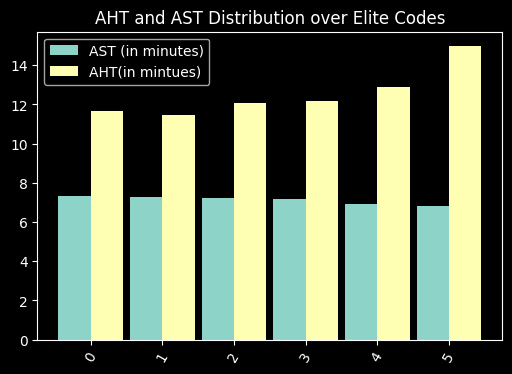

In [122]:
plt.figure(figsize=(6, 4))
plt.bar(
    df_new_2.elite_level_code,
    df_new_2.waiting_time,
    width = -0.45,
    label = "AST (in minutes)",
    align = "edge",
)
plt.bar(
    df_new_2.elite_level_code,
    df_new_2.handle_time,
    align = "edge",
    width = 0.45,
    label = "AHT(in mintues)",
)
plt.xticks(rotation=60)
plt.legend()
plt.title("AHT and AST Distribution over Elite Codes")
plt.show()

#### We Can see that the AHT is increasing with increase in Elite Code but AST is still the same .

### Distribution of Reason of Calling over the The Different Ellte Code 

In [123]:
Dict = {}
for elite,reason in tqdm(df_merged_1[['elite_level_code','primary_call_reason']].values):
    if(Dict.get(reason,-1) == -1):
        Dict[reason] = {}
    dict_ = Dict[reason]
    if(dict_.get(elite,-1)==-1):
        dict_[elite] = 0 
    dict_[elite]+=1

100%|██████████| 42694/42694 [00:00<00:00, 106719.58it/s]


In [124]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(Dict)
df.sort_index(inplace=True)
df

,Voluntary Cancel,Upgrade,Seating,Mileage Plus,IRROPS,Voluntary Change,Post Flight,Check In,Other Topics,Communications,Digital Support,Products Services,Schedule Change,Baggage,Booking,Checkout,Traveler Updates,ETC,Unaccompanied Minor,Disability
0.0,336,556.0,1307,1136,2638,2203,829,376,152,747,247,674,144,583.0,525,395,204,195,17,74
1.0,304,583.0,1218,1133,2605,2241,878,360,179,804,268,662,145,633.0,523,350,181,167,19,85
2.0,171,282.0,624,1172,1373,1080,473,196,77,395,123,346,69,290.0,250,196,99,198,9,45
3.0,107,215.0,435,1038,870,719,307,148,52,274,86,217,45,202.0,186,124,65,160,8,26
4.0,34,NaN,134,722,298,191,91,43,10,78,19,75,21,NaN,62,34,11,127,2,9
5.0,20,NaN,55,650,145,117,33,20,8,32,13,32,9,NaN,26,20,12,105,5,3


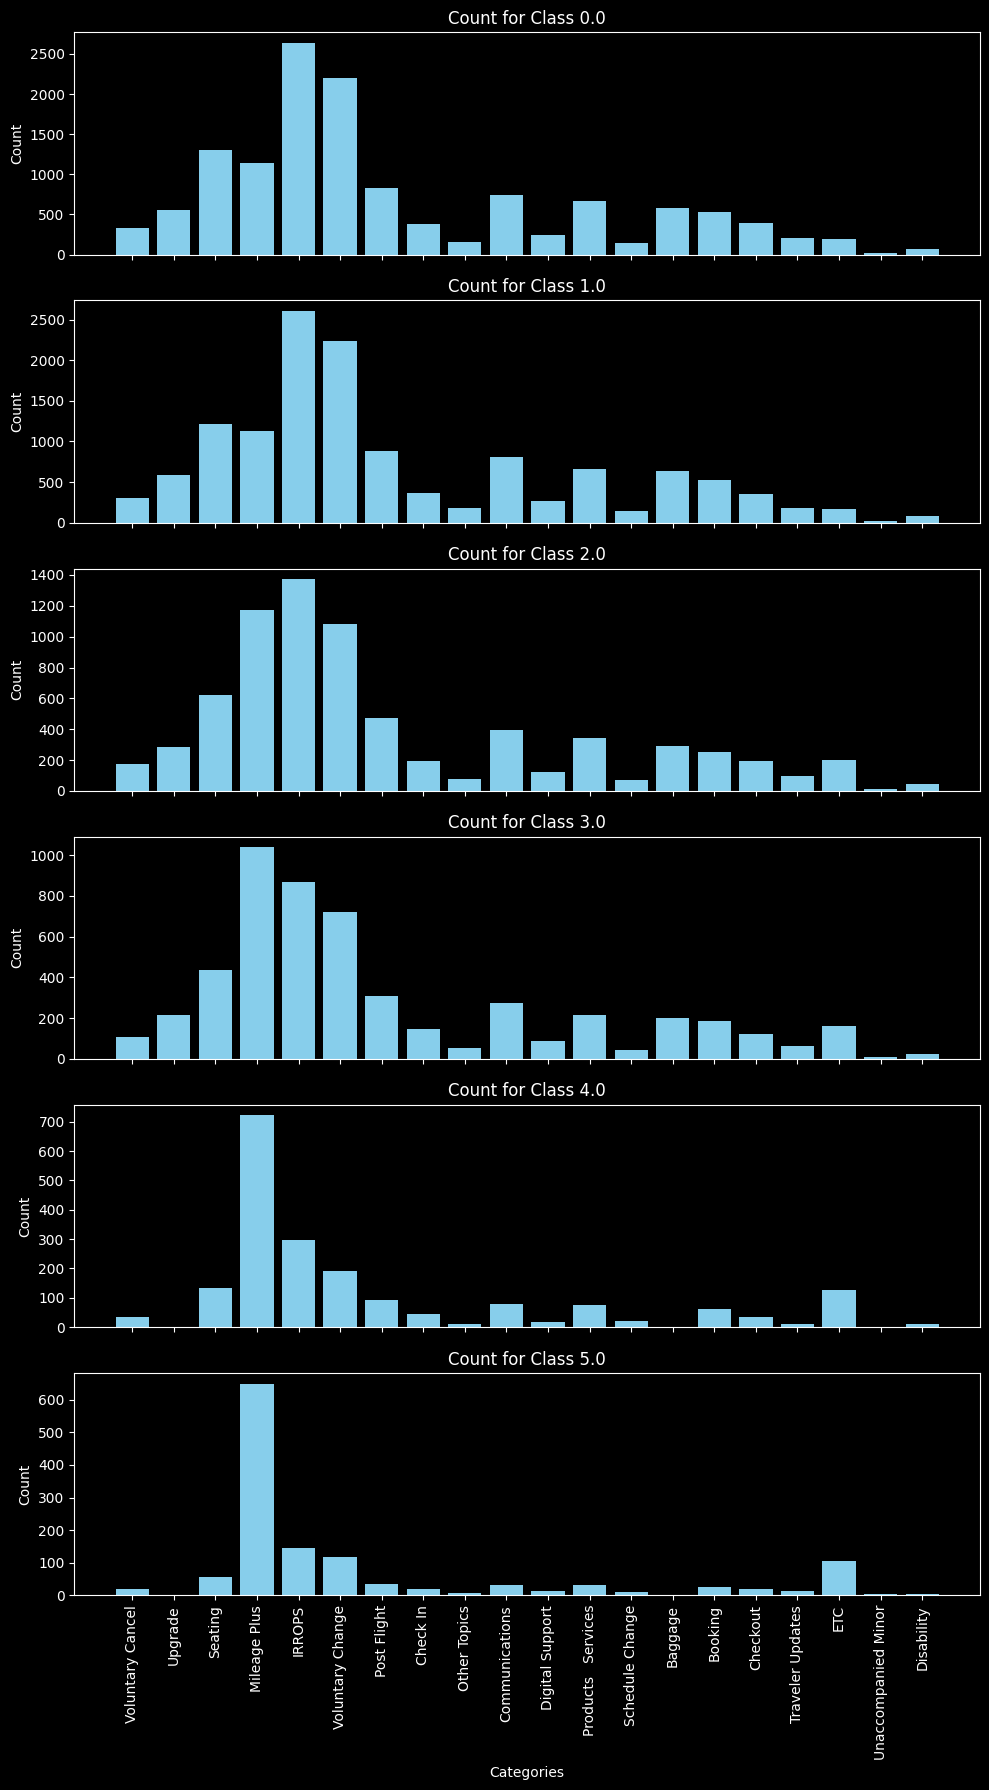

In [86]:
# Create a figure and axes for each class
class_labels = df.columns
num_classes = len(df.index)

fig, axes = plt.subplots(num_classes, 1, figsize=(10, 3 * num_classes), sharex=True)

# Plotting each class on a separate subplot
for i, (class_label, ax) in enumerate(zip(df.index, axes)):
    ax.bar(class_labels, df.loc[class_label], color='skyblue')
    ax.set_title(f'Count for Class {class_label}')
    ax.set_ylabel('Count')
    # ax.set_ylim(0, df.values.max() + 100)  # Adjust y-limit based on max value for better visibility

# Set the common x-label for all subplots
axes[-1].set_xlabel('Categories')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### We Can See the Main Reason for Customers with Higher Elite Code if Mileage Plus

#### We Can See the Main Reason for Customers with Lower Elite Code if Mileage Plus IRROPs and Volountary Change

#### > Effect fo Peak Hours on Elite Code 

In [87]:
# peek hours were 8 am to 18 pm 
peak_call_elite = {}
non_peak_call_elite = {}
for rank in np.unique(df_merged_1['elite_level_code']):
    peak_call_elite[rank] = 0
    non_peak_call_elite[rank] = 0 
    
for dt,rank in tqdm(df_merged_1[["call_start_datetime","elite_level_code"]].values):
    time = str(dt).split(' ')[-1]
    hour = int(time.split(':')[0]) #Converted into hours .
    if(8 <= hour and hour <=18): # Peak Hours 
        peak_call_elite[rank] += 1
    else:                     # Non peak Hours
        non_peak_call_elite[rank] += 1

100%|██████████| 42694/42694 [00:01<00:00, 27492.60it/s]


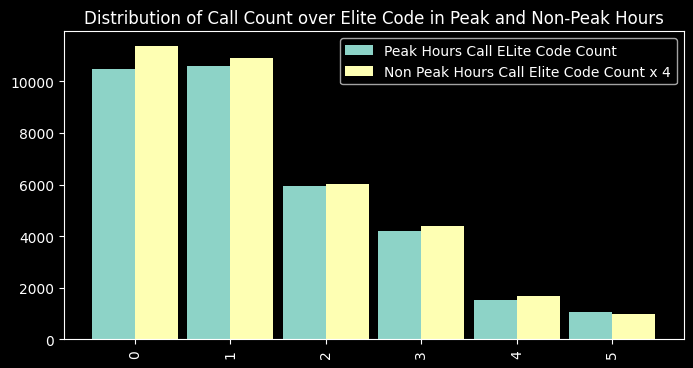

In [89]:
plt.figure(figsize=(8, 4))
plt.bar(
    peak_call_elite.keys(),
    peak_call_elite.values(),
    width = -0.45,
    label = "Peak Hours Call ELite Code Count",
    align = "edge",
)
plt.bar(
    non_peak_call_elite.keys(),
    np.array(list(non_peak_call_elite.values()))*4,
    align = "edge",
    width = 0.45,
    label = "Non Peak Hours Call Elite Code Count x 4",
)
plt.xticks(rotation=90)
plt.legend()
plt.title("Distribution of Call Count over Elite Code in Peak and Non-Peak Hours")
plt.show()

#### Implies there is no effect of peak hours && unpeak hours on the relative ration of amond the elite group calling.

In [90]:
Ivr_merged_df_encoded = df_merged_1[df_merged_1.is_ivr_agent==1]
Non_Ivr_merged_df_encoded = df_merged_1[df_merged_1.is_ivr_agent==0]

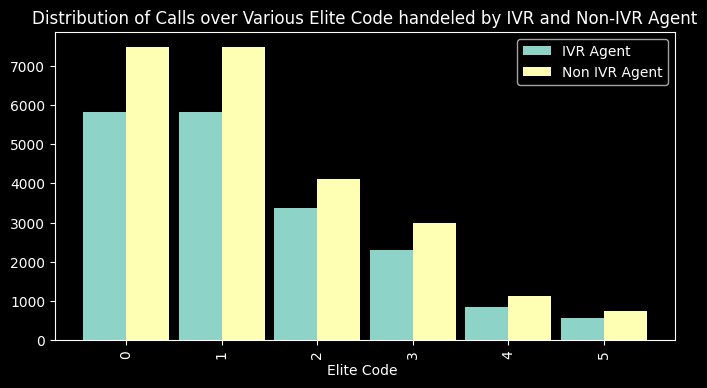

In [91]:
Dict1 = dict(Counter(Ivr_merged_df_encoded.elite_level_code))
Dict2 = dict(Counter(Non_Ivr_merged_df_encoded.elite_level_code))

plt.figure(figsize=(8, 4))
plt.bar(
    Dict1.keys(),
    Dict1.values(),
    width = -0.45,
    label = "IVR Agent",
    align = "edge",
)
plt.bar(
    Dict2.keys(),
    Dict2.values(),
    align = "edge",
    width = 0.45,
    label = "Non IVR Agent",
)
plt.xticks(rotation=90)
plt.legend()
plt.title("Distribution of Calls over Various Elite Code handeled by IVR and Non-IVR Agent")
plt.xlabel("Elite Code ")
plt.show()

#### There is no differnce we could see for elite code to the agent handeling them is IVR or Non-IVR. 